# Customer Churn Prediction with XGBoost

This notebook demonstrates how to use XGBoost for predicting customer churn. The workflow includes data preparation, handling class imbalance, model training, evaluation, threshold tuning, hyperparameter optimization, and feature importance analysis.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns




In [2]:
df = pd.read_csv(r"C:\Users\johnk\customer churn prediction\Data\processed_data.csv")
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_DSL,InternetService_Fiber optic,InternetService_No,IsLongTerm,NumServices,HighRiskPaymentMethod,SeniorAlone
0,0,0,1,0,1,0,0,0,1,0,...,0,1,0,1,0,0,0,1,1,0
1,1,0,0,0,34,1,0,1,0,1,...,0,0,1,1,0,0,1,3,0,0
2,1,0,0,0,2,1,0,1,1,0,...,0,0,1,1,0,0,0,3,0,0
3,1,0,0,0,45,0,0,1,0,1,...,0,0,0,1,0,0,1,3,0,0
4,0,0,0,0,2,1,0,0,0,0,...,0,1,0,0,1,0,0,1,1,0


## Train-Test Split and Handling Class Imbalance

We split the data into training and test sets, ensuring stratification to preserve class distribution.  
To address class imbalance, we apply SMOTE (Synthetic Minority Over-sampling Technique) **only to the training set** to avoid data leakage.

In [ ]:
from imblearn.over_sampling import SMOTE

# Separate features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

# Split before applying SMOTE to avoid data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Apply SMOTE on training set only to avoide leackage
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


c:\Users\johnk\anaconda3\envs\jovani\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [4]:
model = XGBClassifier(random_state=42)
model.fit(X_train_smote, y_train_smote)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [5]:
# Predict class (0 or 1)
y_pred = model.predict(X_test)

# Predict churn probability
y_proba = model.predict_proba(X_test)[:, 1]  # Probability of churn (class 1)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report

# Binary predictions
y_pred = model.predict(X_test)

# Probabilities for class 1 (churn)
y_proba = model.predict_proba(X_test)[:, 1]
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print all metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(report)


Accuracy: 0.7711
Precision: 0.5689
Recall: 0.5740
F1 Score: 0.5714
ROC AUC Score: 0.8041

Confusion Matrix:
[[1305  244]
 [ 239  322]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.84      0.84      1549
           1       0.57      0.57      0.57       561

    accuracy                           0.77      2110
   macro avg       0.71      0.71      0.71      2110
weighted avg       0.77      0.77      0.77      2110



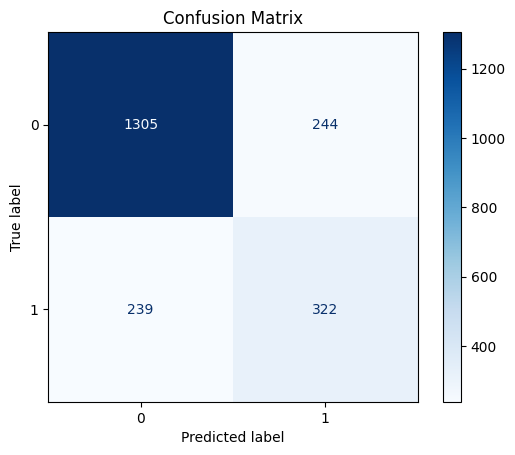

In [7]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


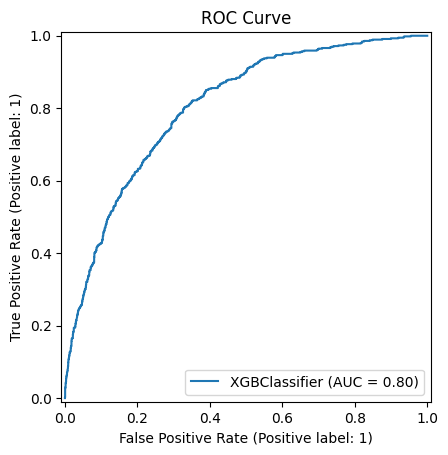

In [8]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.title("ROC Curve")
plt.show()


## Threshold Tuning

Since the dataset is imbalanced, the default threshold of 0.5 may not be optimal.  
We experiment with different probability thresholds and observe how precision, recall, and F1-score change.  
This helps in selecting a threshold that best fits the desired business objective (e.g., maximizing recall for churners).

In [9]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

thresholds = np.arange(0.1, 0.9, 0.05)
for thresh in thresholds:
    y_pred_thresh = (y_proba >= thresh).astype(int)
    precision = precision_score(y_test, y_pred_thresh)
    recall = recall_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)
    print(f"Threshold: {thresh:.2f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1 Score: {f1:.4f}")


Threshold: 0.10 | Precision: 0.4233 | Recall: 0.8556 | F1 Score: 0.5664
Threshold: 0.15 | Precision: 0.4528 | Recall: 0.8217 | F1 Score: 0.5839
Threshold: 0.20 | Precision: 0.4707 | Recall: 0.7861 | F1 Score: 0.5888
Threshold: 0.25 | Precision: 0.4842 | Recall: 0.7362 | F1 Score: 0.5842
Threshold: 0.30 | Precision: 0.5006 | Recall: 0.6988 | F1 Score: 0.5833
Threshold: 0.35 | Precision: 0.5116 | Recall: 0.6684 | F1 Score: 0.5796
Threshold: 0.40 | Precision: 0.5308 | Recall: 0.6292 | F1 Score: 0.5759
Threshold: 0.45 | Precision: 0.5455 | Recall: 0.5989 | F1 Score: 0.5709
Threshold: 0.50 | Precision: 0.5689 | Recall: 0.5740 | F1 Score: 0.5714
Threshold: 0.55 | Precision: 0.5808 | Recall: 0.5383 | F1 Score: 0.5587
Threshold: 0.60 | Precision: 0.6004 | Recall: 0.5009 | F1 Score: 0.5462
Threshold: 0.65 | Precision: 0.6058 | Recall: 0.4492 | F1 Score: 0.5159
Threshold: 0.70 | Precision: 0.6283 | Recall: 0.4189 | F1 Score: 0.5027
Threshold: 0.75 | Precision: 0.6375 | Recall: 0.3636 | F1 Score:

In [10]:
final_pred = (y_proba >= 0.25).astype(int)


In [11]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Apply best threshold
final_pred = (y_proba >= 0.3).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, final_pred)
print("Confusion Matrix:\n", cm)

# Accuracy
acc = accuracy_score(y_test, final_pred)
print(f"\nAccuracy: {acc:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, final_pred))


Confusion Matrix:
 [[1158  391]
 [ 169  392]]

Accuracy: 0.7346

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.75      0.81      1549
           1       0.50      0.70      0.58       561

    accuracy                           0.73      2110
   macro avg       0.69      0.72      0.69      2110
weighted avg       0.77      0.73      0.75      2110



In [12]:
from sklearn.model_selection import GridSearchCV

# Define the XGBoost model
xgb_model = XGBClassifier()

# Hyperparameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 7, 10],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5]
}

# Use GridSearchCV to search for the best hyperparameters
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train_smote, y_train_smote)

# Get the best parameters
print("Best Hyperparameters:", grid_search.best_params_)


Fitting 3 folds for each of 4860 candidates, totalling 14580 fits
Best Hyperparameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 500, 'subsample': 0.8}


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Instantiate model with best hyperparameters
best_model = XGBClassifier(
    colsample_bytree=0.8,
    gamma=0,
    learning_rate=0.01,
    max_depth=7,
    min_child_weight=1,
    n_estimators=500,
    subsample=0.8,
    random_state=42
)
# Train the model on smote
best_model.fit(X_train_smote, y_train_smote)

# Predict
y_pred = best_model.predict(X_test)

# Evaluate
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


Confusion Matrix:
 [[1298  251]
 [ 218  343]]

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.84      0.85      1549
           1       0.58      0.61      0.59       561

    accuracy                           0.78      2110
   macro avg       0.72      0.72      0.72      2110
weighted avg       0.78      0.78      0.78      2110

Accuracy: 0.7777251184834123


## Feature Importance Analysis

We analyze and visualize the most important features according to the trained XGBoost model.  
This helps in understanding which factors contribute most to customer churn.

In [14]:
# Get booster from the fitted model
booster = model.get_booster()

# Get importance scores
importance_dict = booster.get_score(importance_type='gain')

# Convert to pandas Series aligned with column names
importances = pd.Series([importance_dict.get(f, 0) for f in X_train_smote.columns], index=X_train_smote.columns)
importances = importances.sort_values(ascending=False)

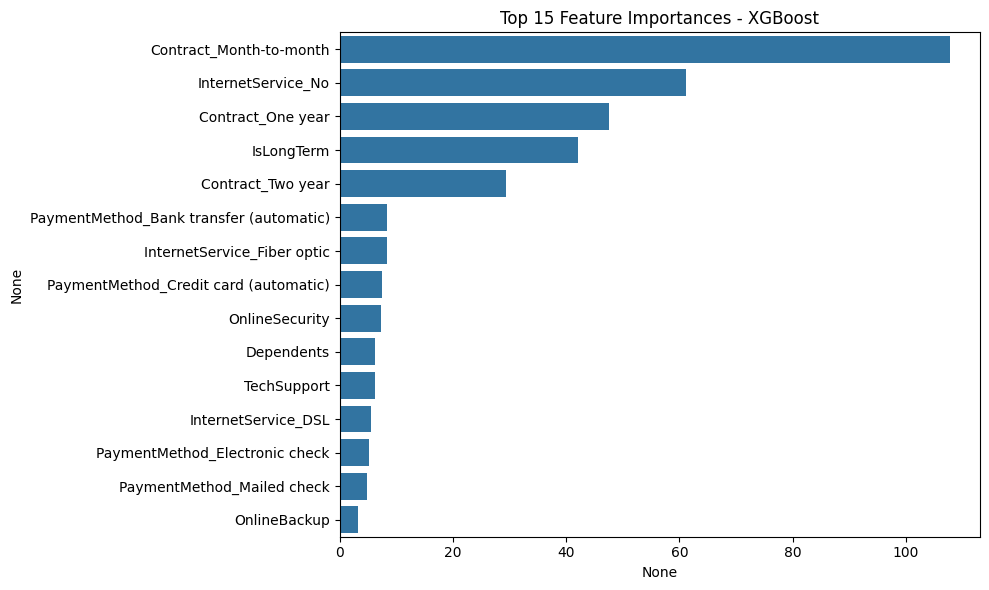

In [15]:


# Plot top 15 features
plt.figure(figsize=(10,6))
sns.barplot(x=importances[:15], y=importances.index[:15])
plt.title('Top 15 Feature Importances - XGBoost')
plt.tight_layout()
plt.show()

In [16]:
# Get top 15 feature names
top_features = importances.head(15).index.tolist()

# Reduce your train and test sets to these features
X_train_top15 = X_train_smote[top_features]
X_test_top15 = X_test[top_features]


In [17]:
from xgboost import XGBClassifier

model_top15 = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
model_top15.fit(X_train_top15, y_train_smote)


y_pred = model_top15.predict(X_test_top15)


c:\Users\johnk\anaconda3\envs\jovani\lib\site-packages\xgboost\core.py:158: UserWarning: [13:24:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [18]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))



[[1281  268]
 [ 237  324]]
              precision    recall  f1-score   support

           0       0.84      0.83      0.84      1549
           1       0.55      0.58      0.56       561

    accuracy                           0.76      2110
   macro avg       0.70      0.70      0.70      2110
weighted avg       0.77      0.76      0.76      2110

Accuracy: 0.7606635071090048


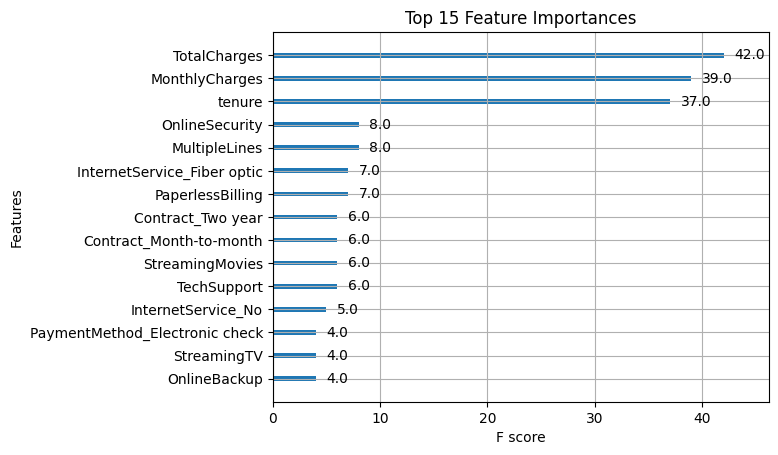

In [19]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plot_importance(best_model, max_num_features=15)
plt.title("Top 15 Feature Importances")
plt.show()


In [20]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict probabilities
y_probs = best_model.predict_proba(X_test)[:, 1]

# Try a different threshold
threshold = 0.38
y_pred_thresh = (y_probs >= threshold).astype(int)


print(confusion_matrix(y_test, y_pred_thresh))
print(classification_report(y_test, y_pred_thresh))


[[1267  282]
 [ 170  391]]
              precision    recall  f1-score   support

           0       0.88      0.82      0.85      1549
           1       0.58      0.70      0.63       561

    accuracy                           0.79      2110
   macro avg       0.73      0.76      0.74      2110
weighted avg       0.80      0.79      0.79      2110



In [22]:
import joblib
joblib.dump(model, 'xgboost_model_full.pkl')

['xgboost_model_full.pkl']

In [23]:
import joblib
joblib.dump(model_top15, 'xgboost_model_top15.pkl')

['xgboost_model_top15.pkl']

### Summary

In this notebook, I built a customer churn prediction model using XGBoost, addressing class imbalance with SMOTE and optimizing model performance through hyperparameter tuning and threshold adjustment.

**Overall, the best model achieved strong recall for churners while maintaining reasonable precision and accuracy.**  
This workflow demonstrates the importance of handling class imbalance, tuning thresholds, and interpreting feature importance in real-world classification problems.
